<h2>  AMAZON Fine Food Reviews Data & Sentiment Analysis</h2>
<h4> 1. Exploratory Data Analysis</h4>
<h4> 2. Sentiment Analysis </h4>
<h5> 3. Using Naive Bayes</h5>
<h5> 4. Logestic Regression by default using l2 Regularizer</h5>
<h5> 5.Logestic Regression by using l1 Regularizer</h5>
<h5> 6. Examining features of Data by Using Feature Engineering</h5>
<h5> 7. Linear SVM Using Hinge loss</h5>
<h5> 8. Calculate Metrics(Confusion Metrics,Precision, Recall, F1 Score,Log loss, Accuracy) for each model</h5>
<h5> 9. Cross Validation and Grid Search for finding optimal regularizer in logistic Regression</h5>
<h5> 10. K-Fold Cross Validation For logistic Regression</h5>
<h5> 11. Comparing all above mentioned Models</h5>

Total number of Reviews=568454
Number of Users= 256059 
Number of Products=74258

In [1]:
# Import Data Set 
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split




/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data from csv file

In [22]:
con= sqlite3.connect('database.sqlite')
data= pd.read_sql_query("Select * from Reviews",con)

In [23]:
# data = pd.read_csv("Reviews.csv")

print data.describe()
print (data.shape)

                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09  
(568454, 10)


### total data points are 568K

In [30]:
# Remove reviews of  Rating=3
# Because we are unable to predict the polarity related to score=3,
# rating 3 review have equall probability to be positive and  negative
df= data[data.Score != 3]
print df.shape

(525814, 10)


In [25]:
# calculate what % of data remaining 
print ((df['Id'].size*1.0)/(data['Id'].size*1.0))*100

92.4989533014


### Get 525K data points after removal of rating 3 reviews, 
### hence we short data by approx 8%


## Data Cleaning:- Data deduplication

In [11]:
# Sorting data according to product Id
sort_data=df.sort_values("ProductId",axis=0, ascending=True)

In [17]:
# Remove duplicates
final=sort_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time'}, keep='first', inplace=False)
final.shape

(328771, 10)

In [16]:
# Calculate what % of data remaining
print (final['Id'].size*1.0)/(sort_data['Id'].size*1.0)*100

62.526102386


In [34]:
# Converting Rating to Binary class i.e high rating=1, low rating=0
df['Score']=final['Score'].apply(lambda x: 1 if (x > 3)  else 0)
print df.head()

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1    1.0  1303862400   
1                     0                       0    0.0  1346976000   
2                     1                       1    1.0  1219017600   
3                     3                       3    NaN  1307923200   
4                     0                       0    1.0  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<h1> a.) Positive Reviews are Common </h1>
<h4> 84% data belongs to positive rating class and 15.6% Reviews are corresponds to negative class rating</h4>

In [6]:
# Count Reviews belonged to High Rating and Low Rating
df2= df1.groupby('Score').size()
print df2

Score
0     82037
1    443777
dtype: int64


Score
0    15.601905
1    84.398095
dtype: float64


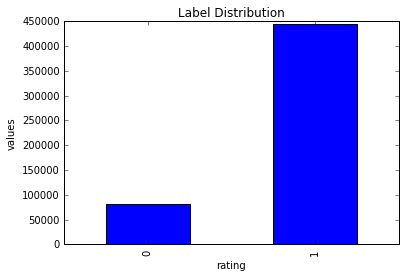

In [7]:
# Calculate Percentage of High Rating and low Rating
per= df2/sum(df2)*100
print per
df2.plot(kind='bar',title='Label Distribution')
plt.xlabel('rating')
plt.ylabel('values')
# plt.legend()
plt.show()

<h2>b.) Positive reviews are shorter in length</h2>

In [8]:
# Calculate Avg. Length of High rating Reviews V/S Low Rating Reviews
df3=df.iloc[:,[6,8]]
df3 = df[df.Score != 3]
df3['Score']=df3['Score'].apply(lambda x: 1 if (x > 3)  else 0)
df3=df3.iloc[:,[6,8]]
df3['Length'] = df3['Summary'].str.len()
df3=df3.iloc[:,[0,2]]
df3=df3.groupby('Score')['Length'].mean()
print df3.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Score
0    24.630981
1    22.975560
Name: Length, dtype: float64


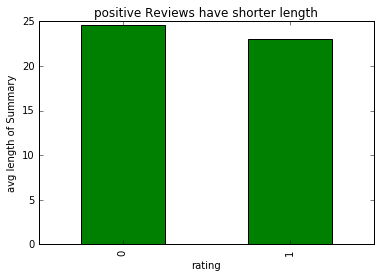

In [7]:
# Plot the Graph between Length of High rating Review V/S Low Level Review
df3.plot(kind='bar',color='g',title='positive Reviews have shorter length')
plt.xlabel('rating')
plt.ylabel('avg length of Summary')
# plt.legend()
plt.show()

<h2>c.) Longer reviews are more helpful</h2>
<h4>we consider reviews are helpul if reviews are known to be helpful by atleast one person, otherwise Excluded </h4>

In [9]:
# Find the co-relation between the helpfullness and  length of the Reviews
df = df[df.Score != 3]
df['Score']=df['Score'].apply(lambda x: 1 if (x > 3)  else 0)
df['Length'] = df['Summary'].str.len()
df4= df[df.HelpfulnessDenominator!=0]
df4['ratio'] = df4['HelpfulnessNumerator']/df4['HelpfulnessDenominator']
df4['ratio']=df4['ratio'].apply(lambda x: 0 if (x < 0.5)  else 1)
df4=df4.groupby('ratio')['Length'].mean()
print df4.head()

ratio
0    23.676342
1    24.246799
Name: Length, dtype: float64


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


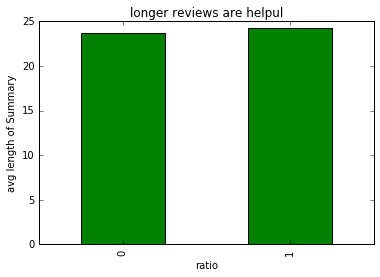

In [9]:
# Plot Histogram between Helpfulness ratio and Length of the Summary
df4.plot(kind='bar',color='g',title='longer reviews are helpul')
plt.xlabel('ratio')
plt.ylabel('avg length of Summary')
# plt.legend()
plt.show()

<h2>d.) Despite being more common and shorter, positive reviews are found more helpful.</h2>
<h4> High rated Reviews are found more helpful than low rated  reviews</h4>

In [10]:
# High rated and longer length Reviews are more helpful than low rated shorter length Reviews
df5= df1[df1.HelpfulnessDenominator!=0]
df5['ratio'] = df5['HelpfulnessNumerator']/df5['HelpfulnessDenominator']
df5['ratio']=df5['ratio'].apply(lambda x: 0 if (x < 0.5)  else 1)
df5['que'] = df5.apply(lambda x : 1 if ((x['Score'] and x['ratio']) ==1) else 0, axis=1)
# print df5.head(3)
df5= df5.groupby('que').size()
print df5

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


que
0     79527
1    194658
dtype: int64


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


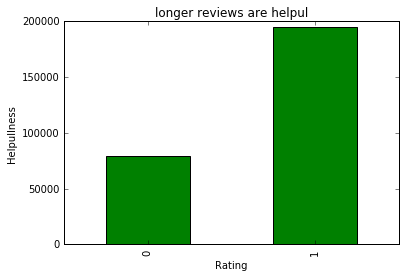

In [11]:
# Plot to show that Positive Reviews are Longer in length
df5.plot(kind='bar',color=['g','r'],title='longer reviews are helpul')
plt.xlabel('Rating')
plt.ylabel('Helpullness')
# plt.legend()
plt.show()

<h2> Model Building Techniques</h2>

In [41]:
#Take only three required columns(Score,Summary, Text) those are necessary in our model
df6=final.iloc[:,[6,8,9]]
df6= df6[df6.Score != 3]
df6['Score']=df6['Score'].apply(lambda x: 1 if (x > 3)  else 0)
df6.Score.value_counts()

1    275651
0     53120
Name: Score, dtype: int64

<h2>  To apply Binary Classification Techniques, change the Score to Positive=1 and Negative=0, Therefor response vector becomes either 0 or 1. </h2>

In [42]:
# For model building consider 1,2 star rating as 0(Low Rating) and 4,5 included as 1(High  Rating)
df6 = df6[pd.notnull(data.Summary)]
# df8['Score']=df8['Score'].apply(lambda x: 1 if (x > 3)  else 0)
print (df6.shape)
# df8.head()


(328771, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<h3> Store data in X, Y format and identify shape  </h3>

In [44]:
# how to define X and y (from the Review  data) for use with COUNTVECTORIZER
X = df6.Summary+df6.Text
y = df6.Score
print(X.shape)
print(y.shape) 


(328771,)
(328771,)


<h3> Sklearn function 'train_test_split' is used to split the data into two parts Train and Test dataset</h3>

In [45]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(246578,)
(82193,)
(246578,)
(82193,)


 <h3> Representing Text Data into Numerical dataset</h3> 'CountVectoriser'- Converting Text into Matrix of token counts

In [46]:
# Create instantiation for CounterVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

### Learn Vocabulary from train dataset 

In [47]:
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm
print type(X_train_dtm)
print (X_train_dtm.shape)
print X_train_dtm[5,:]

<class 'scipy.sparse.csr.csr_matrix'>
(246578, 156009)
  (0, 35281)	1
  (0, 99575)	1
  (0, 72529)	1
  (0, 123636)	1
  (0, 117549)	1
  (0, 148504)	1
  (0, 57790)	1
  (0, 84682)	1
  (0, 70832)	1
  (0, 61822)	1
  (0, 83582)	1
  (0, 128446)	1
  (0, 65947)	1
  (0, 98927)	1
  (0, 38301)	1
  (0, 69203)	1
  (0, 43451)	1
  (0, 6381)	1
  (0, 140183)	1
  (0, 150061)	1
  (0, 8646)	1
  (0, 74496)	1
  (0, 141310)	1
  (0, 77104)	1


## Conclusion:-
#### The Strategy of tokenization, Counting and Normalization is called BoW(Bag of Words). It is completely ignoring the order in which words occur within text. Keep only the frequency of words.

In [48]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<82193x156009 sparse matrix of type '<type 'numpy.int64'>'
	with 4476476 stored elements in Compressed Sparse Row format>

<h3>Model Building Using Naive Bayes</h3>

In [49]:
# Create instantiation of Multinomial Naive bayes and from that check about various parameters
#by default laplace smooting i.e. alpha=1.0
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()


In [50]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
# to know how much time this command will take for execution
%time nb.fit(X_train_dtm, y_train)

CPU times: user 296 ms, sys: 160 ms, total: 456 ms
Wall time: 2.89 s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
# Visulize the effects on term matrix after fitted vocabulary in the model
print type(X_train_dtm)
print (X_train_dtm.shape)
print (X_test_dtm)

<class 'scipy.sparse.csr.csr_matrix'>
(246578, 156009)
  (0, 7584)	1
  (0, 8766)	2
  (0, 8969)	1
  (0, 23937)	1
  (0, 24112)	2
  (0, 31714)	1
  (0, 33347)	4
  (0, 44667)	1
  (0, 46355)	1
  (0, 46514)	1
  (0, 47759)	2
  (0, 52195)	1
  (0, 54699)	1
  (0, 55341)	2
  (0, 58584)	3
  (0, 58941)	1
  (0, 60779)	1
  (0, 62302)	1
  (0, 62539)	1
  (0, 64328)	1
  (0, 69517)	1
  (0, 69646)	1
  (0, 74637)	1
  (0, 74927)	1
  (0, 75528)	2
  :	:
  (82192, 119853)	1
  (82192, 120487)	1
  (82192, 124069)	1
  (82192, 131156)	2
  (82192, 132362)	2
  (82192, 133219)	1
  (82192, 133837)	3
  (82192, 136954)	1
  (82192, 137198)	2
  (82192, 138655)	2
  (82192, 139367)	3
  (82192, 139399)	10
  (82192, 140087)	1
  (82192, 140183)	3
  (82192, 141310)	5
  (82192, 141758)	1
  (82192, 143473)	1
  (82192, 146566)	2
  (82192, 149976)	2
  (82192, 150006)	1
  (82192, 150488)	1
  (82192, 151591)	1
  (82192, 151870)	1
  (82192, 152249)	2
  (82192, 154462)	2


In [52]:
# Predict function is used to predict to which class Test Review Belongs to.
y_pred_class = nb.predict(X_test_dtm)
print y_pred_class

[0 1 1 ..., 1 0 1]


In [53]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test, y_pred_class)
print gb

[[ 9820  3414]
 [ 2912 66047]]


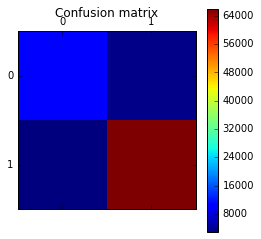

In [54]:
#Plot of Confusion Metric
import matplotlib as plt
from sklearn.metrics import confusion_matrix
import pylab as pl
pl.matshow(gb)
# cm = metrics.confusion_matrix(y_test, y_pred_class, labels=['FAKE', 'REAL'])
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

<h3> Accuracy =TP+TN/TP+TN+FP+FN </h3>

In [55]:
# calculate accuracy of class predictions
from sklearn import metrics
acc= metrics.accuracy_score(y_test, y_pred_class)
print acc

0.923034808317


<h4>Classification Error, Counts the Diagonal Off elements
 FP+FN / (TP+TN+FP+FN)</h4>

In [56]:
#eqivalent to 1-accuracy
error=1-acc
print error

0.076965191683


<h2> Precision-Recall</h2>
<h5>Recall- True Positive Rate or Senstivity or probability of detection
TPR=TP/TP+FN. It defines what fraction of all positive instances does the classifier correctly identify as positive</h5>

In [57]:
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
print recall

0.957772009455


<h5>Precision- 
TPR=TP/TP+FP. It defines what fraction of positive predictions are correct</h5>

In [58]:
#precision From above Confusion Metric
pre=(gb[1,1]+0.0)/sum(gb[:,1])
print pre

0.950850117332



<h3>F1- Score Combining Precision and Recall in to a Single number
F1= (2*Precision * Recall)/(Precision+Recall) </h3>

In [59]:
# caculating F1 Score By using HP i.e 
#F1=2*TP/2*TP+FP+FN
F1=(2*pre*recall)/(pre+recall)
print F1

0.954298511776


<h2>Evaluation Metrices By Using sklearn Lib</h2>

In [60]:
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Accuracy must be greater than 84% in this case because without any model text belong to positive class
# is 84%, this is imbalanced data set
print('Accuracy', metrics.accuracy_score(y_test, y_pred_class))
print('Recall',metrics.recall_score(y_test,y_pred_class))
print('Precision' ,metrics.precision_score(y_test,y_pred_class))
print('F1-Score',metrics.f1_score(y_test,y_pred_class))


('Accuracy', 0.92303480831701001)
('Recall', 0.95777200945489349)
('Precision', 0.95085011733202807)
('F1-Score', 0.95429851177575498)


In [61]:
from sklearn.metrics import classification_report
print classification_report(y_test,y_pred_class,target_names=['Negative','Positive'])

             precision    recall  f1-score   support

   Negative       0.77      0.74      0.76     13234
   Positive       0.95      0.96      0.95     68959

avg / total       0.92      0.92      0.92     82193



In [62]:
# print message text for the false positives (positive review incorrectly classified as negative)
X_test[(y_pred_class==1)&(y_test==0)].count

<bound method Series.count of 402400    NastyRanch is my favorite dressing and I know ...
504035    Peanut flavored oily spoogeI'm used to Peter P...
481303    These are not Green Lentils -All the labeling ...
434991    Not for me.Personally, this was not strong eno...
540099    Great for your gums, but ironically terrible f...
484561    Didn't seem to work for me.For what ever reaso...
192047    not worth the caloriesThese cookies are dry an...
564047    Temptations could do SO much better!Well first...
371923    Dont Buy Falls apart VERY easily!!!!I bought o...
225963    Way overpricedPreposterous.  This is over twic...
493733    Not my favorite way to start the day...I did n...
451582    Celiac CAUTION: Contains Barley MaltWhen first...
88279     Price GougingI started buying these about 6 ye...
280511    Too much sugar for my taste, contains wheatI w...
82588     not much flavorI like some of the other flavor...
179250    With the recent changes, Cost outweighs, Disap...
89646     

In [63]:
# calculate predicted probabilities for X_test_dtm 
# We predict the class-membership probability of the samples via the predict_proba method.
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
y_pred_prob

array([  2.48212940e-04,   9.99999996e-01,   9.94759596e-01, ...,
         9.98729328e-01,   1.59501890e-01,   9.99999995e-01])

In [64]:
# calculate AUC with probabilities values
roc_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print roc_auc

0.943826389795


('ROC Rate', 0.94382638979543754)


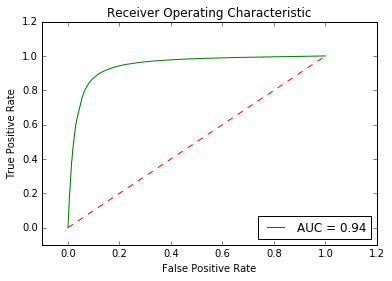

In [65]:
# calculate AUC without probabilities values
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('ROC Rate', roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'g',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4>Compute Log Loss</h4>

In [66]:
from sklearn.metrics import log_loss
log_error=log_loss(y_test, y_pred_prob)
print log_error

0.39797765899


<h3>Logestic Regression</h3>

In [67]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()


In [68]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 3min 28s, sys: 0 ns, total: 3min 28s
Wall time: 3min 36s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
# make class predictions for X_test_dtm
y1_pred_class = logreg.predict(X_test_dtm)
print y1_pred_class

[0 1 1 ..., 1 0 1]


In [70]:
# print the confusion matrix
cm= metrics.confusion_matrix(y_test, y1_pred_class)
print cm

[[10269  2965]
 [ 1839 67120]]


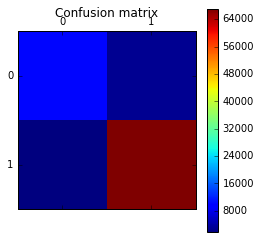

In [71]:
# Plot confusion Metric
import matplotlib as plt
from sklearn.metrics import confusion_matrix
import pylab as pl
pl.matshow(cm)
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

In [72]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y1_pred_prob = logreg.predict_proba(X_test_dtm)[:,1]
y1_pred_prob

array([ 0.00644922,  0.99976507,  0.97654491, ...,  0.99180791,
        0.40633496,  0.98563874])

In [73]:
# Calculating ROC Rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y1_pred_prob)
roc_lg = auc(false_positive_rate, true_positive_rate)
print('ROC Rate', roc_lg)

('ROC Rate', 0.96410475373570992)


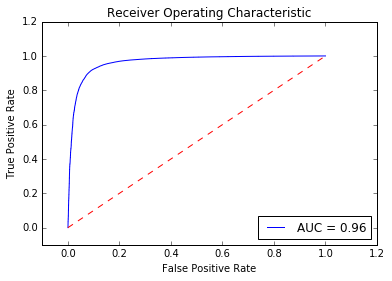

In [74]:
# PLot AUC For Logistic Regression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_lg)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4>Computing Logg Loss</h4>

In [75]:
# With Probabilities
from sklearn.metrics import log_loss
log_error=log_loss(y_test, y1_pred_prob)
print log_error

0.173947534993


<h4>Evaluation Metrics for Logestic Regression</h4>

In [76]:
# calculate accuracy,precision,recall,F1 score
print('Accuracy', metrics.accuracy_score(y_test, y1_pred_class))
print('Recall', metrics.recall_score(y_test,y1_pred_class))
print('Precision', metrics.precision_score(y_test,y1_pred_class))
print('F1 Score', metrics.f1_score(y_test,y1_pred_class))

('Accuracy', 0.94155220030902875)
('Recall', 0.97333197987209796)
('Precision', 0.957694228436898)
('F1 Score', 0.96544978567935325)


In [77]:
#  classification_report
print classification_report(y_test,y1_pred_class,target_names=['Negative','Positive'])

             precision    recall  f1-score   support

   Negative       0.85      0.78      0.81     13234
   Positive       0.96      0.97      0.97     68959

avg / total       0.94      0.94      0.94     82193



<h4>Logestic Regression through L1 Regularization</h4>

In [78]:
from sklearn.linear_model import LogisticRegression
logreg1 = LogisticRegression(penalty='l1',C=1)
%time logreg1.fit(X_train_dtm, y_train)

CPU times: user 25.1 s, sys: 444 ms, total: 25.6 s
Wall time: 33.6 s


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
# make class predictions for X_test_dtm
y2_pred_class = logreg1.predict(X_test_dtm)

In [80]:
# print the confusion matrix
cml1= metrics.confusion_matrix(y_test, y2_pred_class)
print cml1

[[10246  2988]
 [ 1899 67060]]


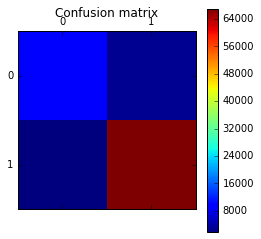

In [81]:
# Plot confusion Metric
import matplotlib as plt
from sklearn.metrics import confusion_matrix
import pylab as pl
pl.matshow(cml1)
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

In [82]:
y2_pred_prob = logreg.predict_proba(X_test_dtm)[:,1]
y2_pred_prob

array([ 0.00644922,  0.99976507,  0.97654491, ...,  0.99180791,
        0.40633496,  0.98563874])

In [83]:
# Calculating ROC Rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y2_pred_prob)
roc_lg = auc(false_positive_rate, true_positive_rate)
print('ROC Rate', roc_lg)

('ROC Rate', 0.96410475373570992)


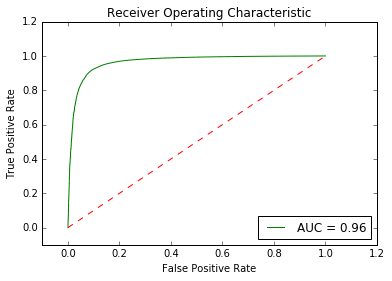

In [84]:
from matplotlib import pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'g',
label='AUC = %0.2f'% roc_lg)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
# Calculating ROC Rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y2_pred_prob)
roc_lg = auc(false_positive_rate, true_positive_rate)
print('ROC Rate', roc_lg)

('ROC Rate', 0.96410475373570992)


In [86]:
# calculate accuracy,precision,recall,F1 score
print('Accuracy', metrics.accuracy_score(y_test, y2_pred_class))
print('Recall', metrics.recall_score(y_test,y2_pred_class))
print('Precision', metrics.precision_score(y_test,y2_pred_class))
print('F1 Score', metrics.f1_score(y_test,y2_pred_class))

('Accuracy', 0.94054238195466766)
('Recall', 0.97246189764932789)
('Precision', 0.95734353586112375)
('F1 Score', 0.96484349709007466)


<h4> computing Log Loss</h4>

In [87]:
# With Probabilities
from sklearn.metrics import log_loss
log_error=log_loss(y_test, y2_pred_prob)
print log_error

0.173947534993


<h2>Examining Model</h2>

In [88]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

156009

In [89]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

[u'00', u'000', u'0000', u'000001', u'00001', u'0001', u'000111052', u'000iu', u'000kwh', u'000mg', u'000s', u'000su', u'000usd', u'000v', u'001', u'00100', u'001bru', u'002', u'0020100604', u'00202', u'00227', u'004', u'00493', u'005', u'00533', u'0060187654', u'0060721855', u'0067575986', u'0069615', u'007', u'00703', u'00704', u'0071468633', u'0071477845', u'008', u'0099', u'00a', u'00absolutely', u'00am', u'00as', u'00b', u'00g', u'00gr', u'00just', u'00lb', u'00pm', u'00s', u'00something', u'00the', u'00to']


In [90]:
# Naive Bayes counts the number of times each token appears in each class
# row 1 represents number of times Low rated reviews token appear and row 2corresponds to high rated Reviews tokens
# Leading underscore is Scikit learn convention that the functionality learns while fitting, use by (_)
nb.feature_count_

array([[  7.82000000e+02,   7.50000000e+01,   0.00000000e+00, ...,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.71500000e+03,   2.84000000e+02,   4.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [91]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 156009)

In [94]:
# number of times each token appears across all Negative REVIEWS
# here we just slicing above feature count
neg_token_count = nb.feature_count_[0, :]
neg_token_count

array([ 782.,   75.,    0., ...,    0.,    1.,    0.])

In [93]:
# number of times each token appears across all POSITIVE REVIEWS
pos_token_count = nb.feature_count_[1, :]
pos_token_count

array([  1.71500000e+03,   2.84000000e+02,   4.00000000e+00, ...,
         1.00000000e+00,   0.00000000e+00,   1.00000000e+00])

In [95]:
# Create a DataFrame of tokens with their separate Negative and Positive Reviews
tokens = pd.DataFrame({'token':X_train_tokens, 'Negative':neg_token_count, 'Positive':pos_token_count}).set_index('token')
tokens.head()

,Negative,Positive
token,,
00,782.0,1715.0
000,75.0,284.0
0000,0.0,4.0
000001,2.0,0.0
00001,1.0,1.0


In [96]:
# examine 5 random DataFrame rows
# It shows the number of times a word appear in neg and pos class
tokens.sample(50, random_state=5)

,Negative,Positive
token,,
antioxis,0.0,1.0
menue,0.0,2.0
openedi,2.0,0.0
regie,0.0,1.0
tay,0.0,4.0
sandwhiches,2.0,11.0
b000fd92z6,0.0,1.0
_______________it,0.0,1.0
lunchif,0.0,1.0


In [97]:
# Naive Bayes counts the number of observations in each class
# it shows that our data is trained on 93426 neg words and 332895 pos word
# In Class_count_  (_)underscore is used because this method is available after model is fitted
nb.class_count_

array([  39886.,  206692.])

In [98]:
# add 1 to neg and pos counts to avoid dividing by 0 
tokens['Negative'] = tokens.Negative+ 1
tokens['Positive'] = tokens.Positive + 1
tokens.sample(5, random_state=6)

,Negative,Positive
token,,
consise,1.0,2.0
peabutter,1.0,3.0
escargotmy,1.0,3.0
paprika,66.0,305.0
benvenuto,1.0,2.0


In [99]:
# convert the negative  and positive counts into frequencies
tokens['Negative']= tokens.Negative / nb.class_count_[0]
tokens['Positive'] = tokens.Positive / nb.class_count_[1]
tokens.sample(5, random_state=6)

,Negative,Positive
token,,
consise,0.000025,0.000010
peabutter,0.000025,0.000015
escargotmy,0.000025,0.000015
paprika,0.001655,0.001476
benvenuto,0.000025,0.000010


In [100]:
# calculate the ratio of Positive-to-Negative for each token
tokens['Positive_ratio'] = tokens.Positive / tokens.Negative
tokens.sample(5, random_state=6)

,Negative,Positive,Positive_ratio
token,,,
consise,0.000025,0.000010,0.385946
peabutter,0.000025,0.000015,0.578919
escargotmy,0.000025,0.000015,0.578919
paprika,0.001655,0.001476,0.891770
benvenuto,0.000025,0.000010,0.385946


<h4>Print 100 top positive features</h4>

In [101]:
# examine the DataFrame sorted by Positive_rate
top=tokens.sort_values('Positive_ratio', ascending=False)
print type(top)
print (top.shape)
print top.head(100)

<class 'pandas.core.frame.DataFrame'>
(156009, 3)
                Negative  Positive  Positive_ratio
token                                             
deliciousi      0.000025  0.003745      149.361194
deliciousthese  0.000025  0.001016       40.524355
deliciousthis   0.000050  0.001805       35.989487
snackthese      0.000025  0.000842       33.577323
yummythis       0.000025  0.000702       27.981102
excellant       0.000025  0.000653       26.051371
biscoff         0.000025  0.000576       22.963801
wonderfuli      0.000025  0.000566       22.577855
acv             0.000025  0.000561       22.384882
nom             0.000075  0.001674       22.256233
yumthis         0.000025  0.000518       20.648124
productgreat    0.000025  0.000513       20.455151
excellenti      0.000050  0.001021       20.358664
coffeegreat     0.000025  0.000484       19.297312
yumi            0.000050  0.000963       19.200825
yummyi          0.000100  0.001911       19.056096
yummm           0.000025  0.0004

<h3> Linear SVM by using SGD</h3>

In [102]:
# fit train data into Model
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
%time clf.fit(X_train_dtm, y_train)

CPU times: user 692 ms, sys: 0 ns, total: 692 ms
Wall time: 725 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [103]:
clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [104]:
# Visulize the effects on term matrix after fitted vocabulary in the model
print type(X_train_dtm)
print (X_train_dtm.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(246578, 156009)


In [105]:
# Predict the class label on test class
ys_pred_class = clf.predict(X_test_dtm)
print (ys_pred_class.shape)

(82193,)


In [106]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
csvm=metrics.confusion_matrix(y_test, ys_pred_class)
print csvm

[[ 9171  4063]
 [ 1636 67323]]


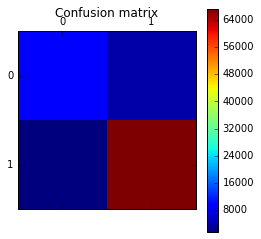

In [107]:
#Plot of Confusion Metric
import matplotlib as plt
from sklearn.metrics import confusion_matrix
import pylab as pl
pl.matshow(csvm)
# cm = metrics.confusion_matrix(y_test, y_pred_class, labels=['FAKE', 'REAL'])
pl.title('Confusion matrix')
pl.colorbar()
pl.show()

<h3>Evaluation Metrics for SVM By Using sklearn Lib</h3>

In [108]:
print('Accuracy', metrics.accuracy_score(y_test, ys_pred_class))
print('Recall',metrics.recall_score(y_test,ys_pred_class))
print('Precision' ,metrics.precision_score(y_test,ys_pred_class))
print('F1-Score',metrics.f1_score(y_test,ys_pred_class))


('Accuracy', 0.93066319516260509)
('Recall', 0.97627575805913658)
('Precision', 0.94308407811055384)
('F1-Score', 0.95939292457871672)


In [109]:
from sklearn.metrics import classification_report
print classification_report(y_test,ys_pred_class,target_names=['Negative','Positive'])

             precision    recall  f1-score   support

   Negative       0.85      0.69      0.76     13234
   Positive       0.94      0.98      0.96     68959

avg / total       0.93      0.93      0.93     82193



In [112]:
# calculate AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, ys_pred_class)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('ROC Rate', roc_auc)

('ROC Rate', 0.83463175843110982)


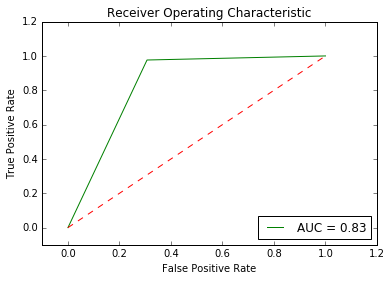

In [111]:
# plot AU-ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'g',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [113]:
from sklearn.metrics import log_loss
log_error=log_loss(y_test, ys_pred_class)
print log_error

2.39484792426


<h2> K- fold Cross Validation for k=3 </h2>

In [114]:
from sklearn import linear_model, datasets
from sklearn.cross_validation import cross_val_score

In [115]:
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
Xlg = vect.fit_transform(X)
Xlg

<328771x185615 sparse matrix of type '<type 'numpy.int64'>'
	with 18053457 stored elements in Compressed Sparse Row format>

In [116]:
xlg=Xlg.toarray


In [117]:
# 3-fold cross-validation with c=100 for logestic regression
logreg = LogisticRegression(C=100)
%time scores = cross_val_score(logreg, Xlg, y, cv=3, scoring='accuracy')
print(scores)

CPU times: user 9min 51s, sys: 1.32 s, total: 9min 52s
Wall time: 10min 6s
[ 0.93448367  0.93327919  0.9351121 ]


In [118]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.934291654802


In [119]:
# 2-fold cross-validation with c=0.05 for logestic regression
logreg = LogisticRegression(penalty='l1',C=0.05)
%time scores = cross_val_score(logreg, Xlg, y, cv=2, scoring='accuracy')
print(scores)

CPU times: user 11.5 s, sys: 624 ms, total: 12.1 s
Wall time: 17 s
[ 0.92919713  0.93055936]


In [120]:
# search for an optimal value of Lambda for Logistic Regression C=1/Lambda
logrg = LogisticRegression(penalty='l1',C=0.05)
L_range = list(range(1,5))
L_scores = []
for l in L_range:
    logreg = LogisticRegression(C=l)
    scores = cross_val_score(logrg, Xlg, y, cv=3, scoring='accuracy')
    L_scores.append(scores.mean())
print(L_scores)

[0.93248188510446439, 0.93248796838456949, 0.93247276004553303, 0.9324849267167622]


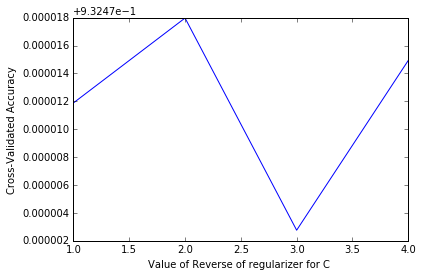

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of Lambda for Logestic Regression(x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(L_range, L_scores)
plt.xlabel('Value of Reverse of regularizer for C ')
plt.ylabel('Cross-Validated Accuracy')

## Tuning  Parameter using `GridSearchCV`

In [122]:
from sklearn.grid_search import GridSearchCV

/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [123]:
# define the parameter values that should be searched
l_range = list(range(1,3))
print(l_range)

[1, 2]


In [124]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid=dict(C=l_range)
print(param_grid)

{'C': [1, 2]}


In [125]:
# instantiate the grid
%time grid = GridSearchCV(logrg, param_grid, cv=3, scoring='accuracy')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 39.1 µs


In [126]:
# fit the grid with data
grid.fit(Xlg, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [127]:
# view the complete results (list of named tuples)
grid.grid_scores_

[mean: 0.93809, std: 0.00072, params: {'C': 1},
 mean: 0.93554, std: 0.00089, params: {'C': 2}]

In [128]:
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print(grid_mean_scores)

[0.9380876050503237, 0.9355417600700792]


<h3> Comparing all the Models on the basis of Metrics</h3>

Parameters|Naive Bayes | Logestic Regression|Loges Regr. L1|Lr SVM
------------| -------------
**TIME**| **2.89 s** |3min 36s|33.6 s|725 ms
**Accuracy**|0.92|**0.94155**|0.94|0.93
**Recall**|0.96|**0.973**|0.972|0.97
**Precision**|0.950|**0.9577**|0.9573|0.94
**F1-Score**|0.954|**0.96544**|0.964|0.95
**AU-ROC**|0.9438|**0.9641**|**0.9641**|0.86230  0.8346
**logloss** |**0.1739**|0.2103|**0.1739**|

#### By using Cross validation, it is found that for C=2 Accuracy is maximum for Logestic Regression 
#### Naive Bayes is faster among others Linear models.
